# LSTM Tutorial
Implementing LSTM based on a tutorial.

## Using someone elses example (example 1)
First, we'll try to replicate the example used [here](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7). 

After working with this a bit, it turns out this example was not even close to complete, and I'm not going to spend a ton of effort debugging it.

In [3]:
# Generate Data
N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

In [4]:
y.shape

(100, 1000)

In [5]:
# Create LSTM Class
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [6]:
a = torch.from_numpy(y[3:, :-1])
b = a.split(1, dim=1)
b[0].shape

torch.Size([97, 1])

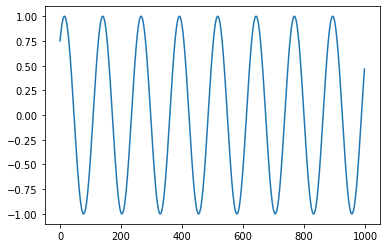

In [7]:
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999)
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999)
test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)
plt.plot(train_target[4])
plt.show()

In [8]:
model = LSTM()
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.08)

In [9]:
def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            future = 1000
            pred = model(test_input, future=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.savefig("predict%d.png"%i, dpi=200)
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [10]:
training_loop(n_epochs = 10,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              train_input = train_input,
              train_target = train_target,
              test_input = test_input,
              test_target = test_target)

NameError: name 'input_t' is not defined